# Librerie

In [194]:
import os
import numpy as np

import torch
import torch.nn as nn
import torchvision.models as models

import matplotlib.pyplot as plt
import imageio.v3 as imageio

from torch.utils.data import Dataset, DataLoader

from pathlib import Path
import pandas as pd
import cv2
import os
from os import sep
import shutil
import json
import yaml
import random
import time
from tqdm.notebook import tqdm_notebook
import concurrent.futures
import multiprocessing as mp

from PIL import Image
from collections import defaultdict
from tqdm import tqdm

from torchvision import transforms

import json
import os
from torch.utils.data import Dataset, DataLoader
from PIL import Image
import random
from torchvision import transforms as T
from torchvision.transforms import functional as TF

from collections import Counter

# DATASET PREPROCESSING

Il nostro dataset è xView, un'analisi preliminare del dataset è presente nel [documento](https://medium.com/picterra/the-xview-dataset-and-baseline-results-5ab4a1d0f47f) linkato.


Questo dataset rappresentava il migliore per il benchmarking di visione artificiale satellitare. La documentazione tecnica spiega che i dati sono ottenuti dai satelliti **WorldView-3**, con una distanza di campionamento al suolo uniforme di 0,3 metri. Ciò conferisce una risoluzione più elevata e omogenea rispetto alla maggior parte degli altri dataset satellitari esistenti all'epoca, molti dei quali si basano invece su fotografie aeree. Quest'ultime, infatti, presentano differenze nella distorsione causate dall'angolo di ripresa, poiché sono scattate da velivoli a bassa quota. 

Il dataset **xView** offre una copertura geografica ampia e diversificata, includendo anche aree meno sviluppate e urbanizzate, fornendo quindi una maggiore varietà di scenari rispetto a dataset più convenzionali. 

### Elenco delle categorie del dataset:  

#### 0-3: Velivoli  
- 0: Fixed-wing Aircraft  
- 1: Small Aircraft  
- 2: Passenger/Cargo Plane  
- 3: Helicopter  

#### 4-15: Veicoli terrestri  
- 4: Passenger Vehicle  
- 5: Small Car  
- 6: Bus  
- 7: Pickup Truck  
- 8: Utility Truck  
- 9: Truck  
- 10: Cargo Truck  
- 11: Truck Tractor w/ Box Trailer  
- 12: Truck Tractor  
- 13: Trailer  
- 14: Truck Tractor w/ Flatbed Trailer  
- 15: Truck Tractor w/ Liquid Tank  

#### 16: Veicoli speciali  
- 16: Crane Truck  

#### 17-22: Veicoli ferroviari  
- 17: Railway Vehicle  
- 18: Passenger Car  
- 19: Cargo/Container Car  
- 20: Flat Car  
- 21: Tank car  
- 22: Locomotive  

#### 23-32: Imbarcazioni  
- 23: Maritime Vessel  
- 24: Motorboat  
- 25: Sailboat  
- 26: Tugboat  
- 27: Barge  
- 28: Fishing Vessel  
- 29: Ferry  
- 30: Yacht  
- 31: Container Ship  
- 32: Oil Tanker  

#### 33-45: Veicoli da costruzione/industriali  
- 33: Engineering Vehicle  
- 34: Tower crane  
- 35: Container Crane  
- 36: Reach Stacker  
- 37: Straddle Carrier  
- 38: Mobile Crane  
- 39: Dump Truck  
- 40: Haul Truck  
- 41: Scraper/Tractor  
- 42: Front loader/Bulldozer  
- 43: Excavator  
- 44: Cement Mixer  
- 45: Ground Grader  

#### 46-51: Edifici e strutture  
- 46: Hut/Tent  
- 47: Shed  
- 48: Building  
- 49: Aircraft Hangar  
- 50: Damaged Building  
- 51: Facility  

#### 52-59: Altre infrastrutture  
- 52: Construction Site  
- 53: Vehicle Lot  
- 54: Helipad  
- 55: Storage Tank  
- 56: Shipping container lot  
- 57: Shipping Container  
- 58: Pylon  
- 59: Tower  

Utilizziamo un processo di preprocessing per il dataset **xView** seguendo i passi presenti in questo [Notebook (Preprocessing)](https://www.kaggle.com/code/ollypowell/xview-dataset-to-yolo-and-coco-format). L'obiettivo è:

1. **Pulizia e riformattazione**: Si parte dal dataset grezzo e lo si prepara per l'addestramento di modelli di intelligenza artificiale per il rilevamento di oggetti.
2. **Suddivisione in chunck**: Poiché le immagini satellitari sono molto grandi, vengono suddivise in "pezzi" più piccoli (chunck) per facilitare l'elaborazione. I bounding box, che definiscono le posizioni degli oggetti nelle immagini, vengono ridimensionati in modo che corrispondano ai nuovi pezzi.
3. **Ottimizzazione del formato**: Le immagini TIFF, che occupano molto spazio, vengono convertite in formato JPG, molto più leggero.
4. **Personalizzazione**: È possibile scegliere la dimensione delle immagini finali e come suddividere i dati per l'addestramento.

Questo processo riduce significativamente la dimensione del dataset, rendendolo più gestibile, senza sacrificare le informazioni necessarie per l'addestramento di modelli come **YOLOv5**.


Dopo aver studiato le considerazioni fatte durante l'analisi del Dataset presenti in questo [Notebook (Exploratory Data Analysis)](https://www.kaggle.com/code/ollypowell/xview-1-dataset-eda?scriptVersionId=157247786) abbiamo scelto di effettuare delle modificare al preprocessing originale fatto nel documento sopra linkato.
In particolare abbiamo osservato che circa il 41% delle chunk con grandezza compresa tra 600x600 e 640x640 risultate prive di label, essendo il dataset originale una raccolta di immagini con almeno una label. Abbiamo deciso di suddividere le immagini originali in chunck più piccoli 320x320, successivamente di eliminare tutte le immagini con le label vuote e considerare per i prossimi passi solo le immagini che portano quindi informazioni utili per il training della rete. Abbiamo, inoltre, corretto alcuni errori presenti nel preprocessing originale che non permettevano di escludere i chunck inferiori ad una certa dimensione.
La scelta di prendere chunck più piccoli è stata presa considerando che suddividere le immagini in parti più piccole ci permette di avere immagini più piccole, massimizzare la probabilità di avere tutte le label del dataset originale e di avere una più facile visualizzazione degli ogetti da individuare anche a occhio umano.
Abbiamo scelto di non considerare i chunck compresi nell'intervallo [300x300, 320x320) essendo un numero irrisorio rispetto ai chunck considerati e richiedendo diverse scelte progettuali su come prendere le immagini di dimensioni diversa e applicare tecniche come stretch che dovevano applicarsi anche sulle coordinate geometriche delle label.

## Setup
To run locally without changing the filepath setup, just copy the relative file structure below:

- For the images: My_Project/Data/X_view/train_images
- For the labels:  My_Project/Data/X_view/train_labels/xView_train.geojson
- For this notebook: My_Project/Python/reformat_yolo.ipynb

You can change the 'My_Project', 'Python', 'reformat_xview.ipynb' to whatever you like.

In [195]:
#Data sources
DATA_FLDR_NM = 'Data'
IN_DATASET_NM = 'xview-dataset'
IMAGE_FLDR_NM = 'train_images'
IN_LABELS_FLDR_NM = 'train_labels'
LABELS_XML_NM = 'xView_train.geojson'

#Output folders and file names
OUT_DATASET_NM = 'xview-yolo-dataset'
CLASS_MAP_JSON_NM = 'xView_class_map.json'
OUT_COCO_JSON_NM = 'COCO_annotations.json'
OUT_IMAGE_FLDR_NM = 'images'
OUT_CFG_FLDR_NM = 'YOLO_cfg'
OUT_DATAFRAME_NM = 'xview_labels.parquet'
YAML_NM = 'xview_yolo.yaml'
CHUNK_WIDTH = 320  # width of the images being created
CHUNK_HEIGHT = 320
MIN_CHUNK_HEIGHT = 320 # no images will be kept if the image chunk is smaller than this
MIN_CHUNK_WIDTH = 320
IMAGE_WRITING = True #True to re-perform image cropping, False just to regenerated other data
TEST_FRACTION = 0.2
JPEG_COMPRESSION = 95 # For the saved files
VAL_FRACTION = 0.2
RANDOM_SEED = 2023
DEBUG = False

in_dataset_pth = Path('/kaggle/input/xview-dataset')
out_dataset_pth = Path('/kaggle/working/')
future_ds_img_fldr = Path(f'/kaggle/working/{OUT_IMAGE_FLDR_NM}')
future_ds_cfg_fldr = Path(f'/kaggle/working/{OUT_CFG_FLDR_NM}')

labels_json_pth = in_dataset_pth / IN_LABELS_FLDR_NM / LABELS_XML_NM
img_fldr_pth = in_dataset_pth / IMAGE_FLDR_NM / IMAGE_FLDR_NM
save_images_fldr_pth = out_dataset_pth / OUT_IMAGE_FLDR_NM 
out_data_parquet_pth = out_dataset_pth / OUT_DATAFRAME_NM
out_json_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM 
class_map_pth = out_dataset_pth / CLASS_MAP_JSON_NM
cfg_fldr_pth = out_dataset_pth / OUT_CFG_FLDR_NM
coco_json_pth = out_dataset_pth / OUT_COCO_JSON_NM
yolo_yaml_pth = cfg_fldr_pth / YAML_NM
train_txt_pth = cfg_fldr_pth / 'train.txt'
val_txt_pth = cfg_fldr_pth / 'train.txt'
test_txt_pth = cfg_fldr_pth / 'test.txt'

def make_empty_dir(directory):
    if directory.is_dir():
        shutil.rmtree(directory)
    os.makedirs(directory)

make_empty_dir(cfg_fldr_pth)
if IMAGE_WRITING:
    make_empty_dir(save_images_fldr_pth)

random.seed(RANDOM_SEED)

print(f'The input images are found at {cfg_fldr_pth}')
print(f'The input labels are found at  {labels_json_pth}')
print(f'Configuration files will be saved to {cfg_fldr_pth}')
print(f'YOLO image files will be saved to {save_images_fldr_pth}')

The input images are found at /kaggle/working/YOLO_cfg
The input labels are found at  /kaggle/input/xview-dataset/train_labels/xView_train.geojson
Configuration files will be saved to /kaggle/working/YOLO_cfg
YOLO image files will be saved to /kaggle/working/images


## Helper Functions

In [196]:
def get_boxes(in_df, class_lst=[]):
    if class_lst:
        in_df = in_df[in_df['TYPE_ID'].isin(class_lst)]
    unique_images = in_df.IMAGE_ID.unique().tolist()
    boxs = {}

    for image in tqdm_notebook(unique_images):
        mask = in_df['IMAGE_ID'] == image
        masked = in_df[mask][['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX']]
        boxs[image] = masked.values.tolist()
    return boxs


def print_first_n_lines(file_path, n):
    try:
        with open(file_path, 'r') as file:
            for line_num, line in enumerate(file, 1):
                if line_num > n:
                    break
                print(line.strip())
    except FileNotFoundError:
        print('Unable to open file')


def load_image(file_pth): #for display
    image_obj = cv2.imread(file_pth)
    image_obj = cv2.cvtColor(image_obj, cv2.COLOR_BGR2RGB)
    return image_obj


def load_bgr_image(file_pth): # for processing only, no need to visualise the image
    image_obj = cv2.imread(file_pth)
    return image_obj

def display_images(image_lst, boxes_dictionary, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    fig, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = str(image_fldr / img_nm)
        img = load_image(image_path)

        # create a bounding box with the data & draw it
        if img_nm in boxes_dictionary:
            for box in boxes_dictionary[img_nm]:
                box_id, x_min, y_min, x_max, y_max = box
                x_min, y_min, x_max, y_max = int(x_min), int(y_max), int(x_max), int(y_min)
                # (left top), (right, bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[box_id]
                    else:
                        box_label = str(box_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return

#Convert YOLO to CV2 rectangle (l,t),(r,b)
def get_corners(x_cen, y_cen, an_width, an_height, im_width, im_height):
    x_cen, y_cen, an_width, an_height = float(x_cen), float(y_cen), float(an_width), float(an_height)
    left = (x_cen - an_width/2)*im_width
    top = (y_cen - an_height/2)*im_height
    right = (x_cen + an_width/2)*im_width
    bottom = (y_cen + an_height/2)*im_height
    return int(left), int(top), int(right), int(bottom)


def display_yolo_images(image_lst, image_fldr, max_images=6, no_cols=1, text=False,  class_map={}):
    total_ims = len(image_lst)
    display_ims = min(max_images, total_ims)
    no_rows = display_ims//no_cols + (display_ims % no_cols > 0)
    _, axs = plt.subplots(no_rows, no_cols, figsize=(10, 10*no_rows/no_cols*3/4))
    axs = axs.flatten()
    for k, img_nm in enumerate(image_lst[:display_ims]):
        image_path = image_fldr / img_nm
        text_fn = image_path.stem + '.txt'
        boxes_path = image_fldr / text_fn
        img = load_image(str(image_path))
        im_h, im_w, _ = img.shape
        with open(boxes_path) as text_file:
            annotations = [line.rstrip().split() for line in text_file]

        # create a bounding box with the data & draw it
        for ann in annotations:
                class_id = ann[0]
                x_centre, y_centre, w, h = ann[1], ann[2], ann[3], ann[4]
                x_min, y_min, x_max, y_max = get_corners(x_centre, y_centre, w, h, im_w, im_h)
                # (left top), (right bottom) == (XMIN, YMIN), (XMAX, YMAX)
                cv2.rectangle(img, (x_min, y_min), (x_max, y_max), (0,255,0), 3)
                if text:
                    if class_map:
                        box_label = class_map[int(class_id)]
                    else:
                        box_label = str(class_id)
                    cv2.putText(img, box_label, (x_min, y_max-10), cv2.FONT_HERSHEY_SIMPLEX, 2, (36,255,12), 4)

        # Show image with bboxes
        axs[k].set_title(f"Image {img_nm}", fontsize = 12)
        axs[k].imshow(img)
        axs[k].set_axis_off()

    # Display all the images
    plt.tight_layout()
    plt.show()
    return


# For a given square within a chunk of a larger image, find any boxes in it
# Return the boxes in YOLO format relative to the chunk boundary
def match_boxes(box_list, chnk_lims):
    boxes_lists = []
    le, to = chnk_lims[0], chnk_lims[1]  # chunk_limits = [c, r, chunk_w, chunk_h]
    w, h  = chnk_lims[2], chnk_lims[3]
    for box in box_list:
        o_left, o_top, o_right, o_bottom = box[1], box[2], box[3], box[4]
        left, right = (o_left - le)/w, (o_right - le)/w  # translate and normalise
        top, bottom = (o_top - to)/h, (o_bottom - to)/h

        h_match = (0 <= left < 1) or (0 < right <= 1)
        v_match = (0 <= top < 1) or (0 < bottom <= 1)

        if v_match and h_match:
            clipped = np.clip([left, top, right, bottom], a_min=0, a_max=1)
            l, t, r, b = clipped[0], clipped[1], clipped[2], clipped[3]
            bounding_box = [str(box[0]),
                            str(round((l + r)/2, 5)),
                            str(round((t + b)/2, 5)),
                            str(round(r-l, 5)),
                            str(round(b-t, 5))]
            boxes_lists.append(bounding_box)
    return boxes_lists

## Data Extraction and Cleaning

In [ ]:
with open(labels_json_pth, 'r') as infile:
    data = json.load(infile)
    keys = list(data.keys())

feature_list = data['features']
COLUMNS = ['IMAGE_ID', 'TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX', 'LONG', 'LAT']

data = []
for feature in tqdm_notebook(feature_list):
    properties = feature['properties'] # a dict
    img_id = properties['image_id']  # '389.tif'
    type_id = properties['type_id']
    bbox = properties['bounds_imcoords'].split(",")  # eg '1917,38,1958,64'
    geometry = feature ['geometry']
    coords = geometry['coordinates'][0] #for some reason it's a list of lists
    long = coords[0][0] / 2  + coords[2][0] / 2
    lat = coords[0][1] / 2  + coords[1][1] / 2
    one_row = [img_id, type_id, bbox[0], bbox[1], bbox[2], bbox[3], long, lat]
    data.append(one_row)

instances = len(data)
print(f'There are {instances} object instances in the original dataset')

Extracting the columns of interest only

In [ ]:
df = pd.DataFrame(data, columns = COLUMNS)
df[['XMIN', 'YMIN', 'XMAX', 'YMAX']] = df[['XMIN', 'YMIN', 'XMAX', 'YMAX']].apply(pd.to_numeric)
df.head()

Removing two erroneous annotation class labels (See [EDA of the xView dataset](https://www.kaggle.com/code/ollypowell/xview-dataset-eda))

In [ ]:
df = df[(df.TYPE_ID != 75) & (df.TYPE_ID != 82)]   # removing erroneous labels
print(f'{instances - len(df)} rows removed, leaving {len(df)} rows')

In [ ]:
df.head()

Also removing anything from image 1395, this image does not exist in the dataset

In [ ]:
old_length = len(df)
df = df[df.IMAGE_ID != '1395.tif']
print(f'{old_length - len(df)} rows removed, leaving {len(df)}')
df.head()

Also it's useful to convert the type IDs into a continuous sequence from 0 to 59 for the 60 categories.  The original competition labels were not arranged this way. The dictionary below is the original mapping from the competition website.

In [ ]:
old_dict = {
    11:'Fixed-wing Aircraft', 12:'Small Aircraft', 13:'Passenger/Cargo Plane', 15:'Helicopter',
    17:'Passenger Vehicle', 18:'Small Car', 19:'Bus', 20:'Pickup Truck', 21:'Utility Truck',
    23:'Truck', 24:'Cargo Truck', 25:'Truck Tractor w/ Box Trailer', 26:'Truck Tractor',27:'Trailer',
    28:'Truck Tractor w/ Flatbed Trailer', 29:'Truck Tractor w/ Liquid Tank', 32:'Crane Truck',
    33:'Railway Vehicle', 34:'Passenger Car', 35:'Cargo/Container Car', 36:'Flat Car', 37:'Tank car',
    38:'Locomotive', 40:'Maritime Vessel', 41:'Motorboat', 42:'Sailboat', 44:'Tugboat', 45:'Barge',
    47:'Fishing Vessel', 49:'Ferry', 50:'Yacht', 51:'Container Ship', 52:'Oil Tanker',
    53:'Engineering Vehicle', 54:'Tower crane', 55:'Container Crane', 56:'Reach Stacker',
    57:'Straddle Carrier', 59:'Mobile Crane', 60:'Dump Truck', 61:'Haul Truck', 62:'Scraper/Tractor',
    63:'Front loader/Bulldozer', 64:'Excavator', 65:'Cement Mixer', 66:'Ground Grader', 71:'Hut/Tent',
    72:'Shed', 73:'Building', 74:'Aircraft Hangar', 76:'Damaged Building', 77:'Facility', 79:'Construction Site',
    83:'Vehicle Lot', 84:'Helipad', 86:'Storage Tank', 89:'Shipping container lot', 91:'Shipping Container',
    93:'Pylon', 94:'Tower'}

Making a new mapping from 0 to 59

In [ ]:
old_keys = sorted(list(old_dict.keys()))
new_dict = {old_dict[x]:y for y, x in enumerate(old_keys)}
class_map_dict = {y:old_dict[x] for y, x in enumerate(old_keys)}
with open(out_json_map_pth, "w") as json_file:
    json.dump(class_map_dict, json_file)
print(class_map_dict)

Now we can convert the dataframe's old TYPE_IDs to their new values

In [ ]:
df['TYPE_ID'] = df['TYPE_ID'].apply(lambda x: new_dict[old_dict[x]])
df.head(3)

Just to check the data is loading sensibly, I'm displaying a couple of images with any transport related annotations.

In [ ]:
all_classes = list(class_map_dict.keys())
transport_only = [x for x in all_classes if x < 48]

boxes = get_boxes(df, transport_only)
images_for_display = random.choices(list(boxes.keys()), k=2)
display_images(images_for_display, boxes, img_fldr_pth, max_images=2, no_cols=2, text=True, class_map=class_map_dict) #adjust as desired

## Main Process
- Break up the large tif files into chunks
- Save those chunks as jpg files
- Check if any chunks contain annotations
- Reformat those annotations into YOLO format: x_center, y_center, width, height (all normalised)
- Write all annotations in YOLO format to a dictionary with the filename as a key

In [ ]:
boxes_dict = get_boxes(df) # returns a dict of the form {filename:[['TYPE_ID', 'XMIN', 'YMIN', 'XMAX', 'YMAX'],[..],[..],..]}

In [ ]:
def process_image(img_fn, 
                  dir_pth=img_fldr_pth, 
                  boxes=boxes_dict, 
                  out_dir=save_images_fldr_pth, 
                  c_height=CHUNK_HEIGHT, 
                  c_width=CHUNK_WIDTH,  
                  jpg_q=JPEG_COMPRESSION,
                  min_h=MIN_CHUNK_HEIGHT,
                  min_w=MIN_CHUNK_WIDTH,
                  writing=IMAGE_WRITING
                 ):
    
    labels_list = boxes[img_fn]
    img_pth = str(dir_pth / img_fn)
    im = load_bgr_image(img_pth)
    full_h, full_w, _ = im.shape
    y_boxes= {}
    f_names, widths, heights = [], [], []
    
    for r in range(0, full_h, c_height):
        for c in range(0, full_w, c_width):
            stem = img_fn.split('.')[0]
            fn = str(f"img_{stem}_{r}_{c}.jpg")
            out_pth = str(out_dir / fn)
            width = c_width
            height = c_height
            if r + height > full_h:
                height = full_h - r
            if c + width > full_w:
                width = full_w - c
            big_enough = (height >= min_h) and (width >= min_w)
            if big_enough:
                if writing:
                    cv2.imwrite(out_pth, im[r:r+height, c:c+height,:],  [int(cv2.IMWRITE_JPEG_QUALITY), jpg_q])
                # Find any boxes occurring in the chunk, and convert to YOLO format
                chunk_limits = [c, r, width, height]
                y_boxes[fn] = match_boxes(labels_list, chunk_limits)
                f_names.append(fn)
                widths.append(width)
                heights.append(height)
    return f_names, widths, heights, y_boxes

In [ ]:
img_fns = df.IMAGE_ID.unique().tolist()
if DEBUG:
    img_fns = img_fns[:len(img_fns)//120]
    df = df[df['IMAGE_ID'].isin(img_fns)]

In [ ]:
start_time = time.time()
num_threads = mp.cpu_count() 
overall_progress = tqdm_notebook(total=len(img_fns), desc="Creating and saving image tiles")
yolo_boxes= {}
file_names, widths, heights = [], [], []

with concurrent.futures.ThreadPoolExecutor(max_workers=num_threads) as executor:
    for f_names, c_widths, c_heights, y_boxes in executor.map(process_image, img_fns):
        file_names.extend(f_names)
        widths.extend(c_widths)
        heights.extend(c_heights)
        yolo_boxes.update(y_boxes)
        overall_progress.update(1)
overall_progress.close()

image_data = {file_names[i]: [widths[i], heights[i]] for i in range(len(file_names))}
time_taken=time.time() - start_time

## Write the new YOLO formatted text files
Iterate through the dictionary, creating a text file for each image:  class x y width height, then save the completed text file to the same location, with the same stem name as the image.

In [ ]:
all_image_files = os.listdir(save_images_fldr_pth)
for image_fn in tqdm_notebook(all_image_files):
    stem = image_fn.split('.')[0]
    fn = str (stem) + '.txt'
    txt_pth = str(save_images_fldr_pth / fn)
    seperator = ' '
    with open(txt_pth, 'a') as f:
        if image_fn in yolo_boxes:
            for bbox in yolo_boxes[image_fn]:
                txt = seperator.join(bbox) + '\n'
                f.write(txt)

In [ ]:
txt_files = [file for file in os.listdir(save_images_fldr_pth) if file.endswith('.txt')]
num_txt_files = len(txt_files)
print(f"Numero di file .txt: {num_txt_files}")

In [ ]:
images_with_boxes = [image_fn for image_fn in all_image_files if image_fn in yolo_boxes]
print(f"Numero di immagini con dati in yolo_boxes: {len(images_with_boxes)}")

In [ ]:
text_paths = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
column_names = ['Class_ID', 'x_center', 'y_center', 'width', 'height']
data = []
for file_path in text_paths:
    with open(file_path, 'r') as file:
        for line in file:
            values = line.strip().split(' ')
            row_data = {col: val for col, val in zip(column_names, values)}
            row_data['File_Name'] = file_path.name
            data.append(row_data)

out_df = pd.DataFrame(data)
out_df['Class_ID']=out_df['Class_ID'].astype(int)
out_df['Class_Name'] = out_df['Class_ID'].map(class_map_dict).fillna('unknown')
out_df = out_df[['File_Name', 'Class_Name', 'Class_ID', 'x_center', 'y_center', 'width', 'height']]
out_df.to_parquet(out_data_parquet_pth, index=False)
out_df.head()

Rimozione immagini senza label

In [ ]:
def remove_empty(image_folder, yolo_boxes, image_data):
    """
    Rimuove file di annotazione vuoti (.txt) e le immagini corrispondenti.
    Aggiorna anche i dizionari yolo_boxes e image_data per rimuovere le voci corrispondenti.
    
    Args:
        image_folder (str): Percorso della cartella contenente immagini e file .txt.
        yolo_boxes (dict): Dizionario con annotazioni YOLO.
        image_data (dict): Dizionario con metadati delle immagini.
    
    Returns:
        tuple: Dizionari aggiornati (yolo_boxes, image_data).
    """
    all_image_files = set(os.listdir(image_folder))  # Set per confronti più veloci
    files_to_remove = []  # Traccia dei file da rimuovere (nomi completi)

    # Controlla i file .txt per annotazioni vuote
    for txt_file in all_image_files:
        if txt_file.endswith('.txt'):
            txt_path = os.path.join(image_folder, txt_file)
            # Controlla se il file è vuoto o contiene solo spazi
            with open(txt_path, 'r') as file:
                content = file.read().strip()
            if not content:  # Vuoto o solo spazi
                # Determina il file immagine corrispondente
                image_file = txt_file.replace('.txt', '.jpg')  # Cambia estensione a .jpg
                files_to_remove.append(image_file)  # Aggiungi immagine alla lista
                os.remove(txt_path)  # Rimuovi file .txt
                # Rimuovi anche il file immagine, se esiste
                image_path = os.path.join(image_folder, image_file)
                if os.path.exists(image_path):
                    os.remove(image_path)

    # Aggiorna yolo_boxes eliminando i file rimossi
    yolo_boxes = {key: value for key, value in yolo_boxes.items() if key not in files_to_remove}

    # Aggiorna image_data eliminando i file rimossi
    image_data = {key: value for key, value in image_data.items() if key not in files_to_remove}

    # Filtra le liste per escludere i file da rimuovere
    filtered_file_names = [name for name in file_names if name not in files_to_remove]
    filtered_widths = [widths[i] for i in range(len(file_names)) if file_names[i] not in files_to_remove]
    filtered_heights = [heights[i] for i in range(len(file_names)) if file_names[i] not in files_to_remove]

    return yolo_boxes, image_data, filtered_file_names, filtered_widths, filtered_heights

In [ ]:
yolo_boxes, image_data, filtered_file_names, filtered_widths, filtered_heights = remove_empty(save_images_fldr_pth, yolo_boxes, image_data)

In [ ]:
# Verifica il numero di file .txt nel folder
txt_files = [f for f in os.listdir(save_images_fldr_pth) if f.endswith('.txt')]
print(f"Numero di file .txt nel folder: {len(txt_files)}")
# Conta il numero di file immagine (per esempio file .jpg)
image_files = [f for f in os.listdir(save_images_fldr_pth) if f.endswith('.jpg')]
num_images = len(image_files)
print(f"Numero di immagini nel folder: {num_images}")
images_with_boxes = [image_fn for image_fn in all_image_files if image_fn in yolo_boxes]
print(f"Numero di immagini con dati in yolo_boxes: {len(images_with_boxes)}")

In [ ]:
from itertools import islice

# Stampa i primi 5 elementi
for key, value in islice(image_data.items(), 5):
    print(f"{key}: {value}")

In [ ]:
num_file_names = len(image_data) # Il numero di chiavi corrisponde al numero di file_names (per ora)
num_widths = len([value[0] for value in image_data.values()])  # Conta tutte le larghezze
num_heights = len([value[1] for value in image_data.values()])  # Conta tutte le altezze

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

In [ ]:
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=True,  class_map=class_map_dict)

In [ ]:
#without text labels
filenames = [x for x in os.listdir(save_images_fldr_pth) if x.endswith(".jpg")]
image_list = random.choices(filenames, k=4)
display_yolo_images(image_list, save_images_fldr_pth, max_images=4, no_cols=2, text=False)

## Splitting

In [ ]:
total_images = len(filenames)
indices = list(range(total_images))
random.shuffle(indices)

train_fraction = 1 - TEST_FRACTION - VAL_FRACTION
train_sp = int(np.floor(train_fraction * len(indices))) # The training-validation split
valid_sp = int(np.floor(VAL_FRACTION * len(indices))) + train_sp # The validation-test split
train_idx, val_idx, test_idx = indices[:train_sp], indices[train_sp:valid_sp], indices[valid_sp:]

print(' Training set size: \t', len(train_idx))
print(' Validation set size: \t', len(val_idx))
print(' Test set size: \t', len(test_idx))
print(' Total dataset: \t', total_images)

Write 3 text files into the Data folder with the file paths: train.txt, val.txt, test.txt  These are lists of absolute filepaths to the images, one line each path.  They can reside anywhere just so long as the relative paths in xview_yolo.yaml points to them.

In [ ]:
files = ['train.txt', 'val.txt', 'test.txt']
splits = [train_idx, val_idx, test_idx]

for fn, split in zip(files, splits):
    txt_pth = cfg_fldr_pth / fn
    with open(txt_pth, 'a') as f:
        for ind in split:
            f.write(str(future_ds_img_fldr / filenames[ind]) + '\n')
        print(f'{fn[:-4]} file written to {txt_pth}, with {len(split) } samples')

## YAML File
Write a .yaml file pointing to the text file locations, and determining class names, number of categories location.
This is good practice, it means I don't need to move all the image files around just to change the training splits.
Also the .yml file gets updated automatically if anybody changes something like the number of classes.

In [ ]:
config = {'train': str(future_ds_cfg_fldr / files[0]),
          'val': str(future_ds_cfg_fldr / files[1]),
          'test': str(future_ds_cfg_fldr / files[2]),
          'nc': len(class_map_dict),
          'names': class_map_dict
          }

with open(yolo_yaml_pth, "w") as file:
    yaml.dump(config, file, default_style=None, default_flow_style=False, sort_keys=False)
print(f'yaml file written to {yolo_yaml_pth}')

## Splitting Check
Just checking the first few lines of the train.txt file

In [ ]:
for split in ['train', 'val', 'test']:
    print(f'{split} text file')
    print_first_n_lines(cfg_fldr_pth / f'{split}.txt', 2)

And the .yaml file

In [ ]:
print_first_n_lines(yolo_yaml_pth, 10)

And a couple of annotations files

In [ ]:
txt_fnames = [save_images_fldr_pth / x for x in os.listdir(save_images_fldr_pth) if x.endswith(".txt")]
text_list = random.choices(txt_fnames, k=2)
print(text_list)
for text_f in text_list:
    print(f'Reading {text_f}')
    print_first_n_lines(text_f, 3)  

In [ ]:
print(text_list)

And the csv file

In [ ]:
out_data = pd.read_parquet(out_data_parquet_pth)
out_data.head()

In [ ]:
# Conta il numero di immagini con nomi unici
num_immagini_uniche = out_data['File_Name'].nunique()
print(f"Il numero di immagini uniche è: {num_immagini_uniche}")

And the `.json`

In [ ]:
with open(out_json_map_pth, "r") as json_file:
    loaded_dict = json.load(json_file)
print(loaded_dict)

## YOLO to COCO
Since it's not too much extra effort at this point, I'll re-format the dataframe into COCO geometry, and write a COCO `.json` file for people with that use in mind.  COCO format is explained [here](https://cocodataset.org/#format-data).  At the top level we mainly need these three objects:

images:  
`{"id": int, "width": int, "height": int, "file_name": str, }`   
annotations:  
`{"id": int, "image_id": int, "category_id": int, "area": float, "bbox": [x,y,width,height]}`  
categories:  
`[{"id": int, "name": str}]`

I'll copy the YOLO DataFrame, obtain the image widths, and create the BBox category:

In [ ]:
num_file_names = len(image_data) # Il numero di chiavi corrisponde al numero di file_names (per ora)
num_widths = len([value[0] for value in image_data.values()])  # Conta tutte le larghezze
num_heights = len([value[1] for value in image_data.values()])  # Conta tutte le altezze

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

In [ ]:
image_data = {'width': filtered_widths, 'height': filtered_heights, 'file_name': filtered_file_names} # Ricreo il dizionario con 3 chiavi ma utilizzando le liste filtraten dopo l'eliminazione fatta prima
im_df = pd.DataFrame(image_data)
im_df['id'] = im_df['file_name'].str.replace(r'\D', '', regex=True).astype(int)
im_df.head()

In [ ]:
num_file_names = len(image_data['file_name'])  # Numero di file rimanenti
num_widths = len(image_data['width'])         # Numero di larghezze rimanenti
num_heights = len(image_data['height'])       # Numero di altezze rimanenti

print(f"Il numero di immagini uniche è: {num_file_names}")
print(f"Il numero di larghezze registrate è: {num_widths}")
print(f"Il numero di altezze registrate è: {num_heights}")

In [ ]:
num_images_in_im_df = len(im_df)
print(f"Numero di immagini in im_df: {num_images_in_im_df}")

In [38]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'width': row['width'],
        'height':row['height'],
        'file_name':row['file_name']
    }

im_list = im_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
[print(val) for val in im_list[:4]]

{'id': 235500, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_0.jpg'}
{'id': 23550320, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_320.jpg'}
{'id': 23550640, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_640.jpg'}
{'id': 23550960, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_960.jpg'}


[None, None, None, None]

Merge the images dataframe with the annotations to work out the absolute pixel values, plus a bit more re-organising.

In [39]:
annotations_df = out_data.copy()
annotations_df['image_id'] = annotations_df['File_Name'].str.replace(r'\D', '', regex=True).astype(int)
annotations_df= annotations_df.rename(columns={'height': 'h', 'width': 'w'})
an_df = annotations_df.merge(im_df, left_on='image_id', right_on='id', how='left')
an_df['x_center']= (an_df['x_center'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['y_center']= (an_df['y_center'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['w']= (an_df['w'].astype(np.float64)*an_df['width']).round(decimals=0)
an_df['h']= (an_df['h'].astype(np.float64)*an_df['height']).round(decimals=0)
an_df['Class_ID']= an_df['Class_ID'].astype(int)
an_df = an_df.drop(columns=['File_Name', 'file_name', 'width', 'height', 'id'])
an_df['left'] = (an_df['x_center'] - an_df['w']/2).round(decimals=0)
an_df['top'] =  (an_df['y_center'] - an_df['h']/2).round(decimals=0)
an_df['bbox'] = ('[' + an_df['left'].astype(str) + ', ' 
              + an_df['top'].astype(str) + ', ' 
              + an_df['w'].astype(str) + ', '
              + an_df['h'].astype(str) + ']')
an_df['area'] = an_df['w'] * an_df['h']
an_df = an_df.drop(columns=['x_center', 'y_center', 'w', 'h', 'left', 'top', 'Class_Name'])
an_df.reset_index(inplace=True)
an_df.rename(columns={'index': 'id'}, inplace=True)
an_df.head()

,id,Class_ID,image_id,bbox,area
0,0,48,22253201920,"[216.0, -0.0, 103.0, 129.0]",13287.0
1,1,5,94320640,"[50.0, 87.0, 17.0, 8.0]",136.0
2,2,5,94320640,"[-0.0, 261.0, 1.0, 12.0]",12.0
3,3,48,94320640,"[236.0, 0.0, 40.0, 6.0]",240.0
4,4,48,94320640,"[188.0, 0.0, 61.0, 28.0]",1708.0


In [40]:
def row_to_dict(row):
    return {
        'id': row['id'],
        'image_id' : row['image_id'],
        'category_id': row['Class_ID'],
        'area':row['area'],
        'bbox':row['bbox']
    }

an_list = an_df.apply(lambda row: row_to_dict(row), axis=1).tolist()
print(an_list[:4])

[{'id': 0, 'image_id': 22253201920, 'category_id': 48, 'area': 13287.0, 'bbox': '[216.0, -0.0, 103.0, 129.0]'}, {'id': 1, 'image_id': 94320640, 'category_id': 5, 'area': 136.0, 'bbox': '[50.0, 87.0, 17.0, 8.0]'}, {'id': 2, 'image_id': 94320640, 'category_id': 5, 'area': 12.0, 'bbox': '[-0.0, 261.0, 1.0, 12.0]'}, {'id': 3, 'image_id': 94320640, 'category_id': 48, 'area': 240.0, 'bbox': '[236.0, 0.0, 40.0, 6.0]'}]


The category mapping is just about in a convenient format already

In [41]:
cat_list = [{key:val} for key,val in class_map_dict.items()]
print(cat_list[:4])

[{0: 'Fixed-wing Aircraft'}, {1: 'Small Aircraft'}, {2: 'Passenger/Cargo Plane'}, {3: 'Helicopter'}]


Now I just need to combine the top level objects, and save to `.json`

In [42]:
out_json_data = {'images': im_list, 'annotations': an_list, 'categories': cat_list}
with open(coco_json_pth, 'w') as json_file:
    json.dump(out_json_data, json_file, indent=4)
    
for key, value in out_json_data.items():
    print(key, value[:5])

images [{'id': 235500, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_0.jpg'}, {'id': 23550320, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_320.jpg'}, {'id': 23550640, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_640.jpg'}, {'id': 23550960, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_960.jpg'}, {'id': 235501280, 'width': 320, 'height': 320, 'file_name': 'img_2355_0_1280.jpg'}]
annotations [{'id': 0, 'image_id': 22253201920, 'category_id': 48, 'area': 13287.0, 'bbox': '[216.0, -0.0, 103.0, 129.0]'}, {'id': 1, 'image_id': 94320640, 'category_id': 5, 'area': 136.0, 'bbox': '[50.0, 87.0, 17.0, 8.0]'}, {'id': 2, 'image_id': 94320640, 'category_id': 5, 'area': 12.0, 'bbox': '[-0.0, 261.0, 1.0, 12.0]'}, {'id': 3, 'image_id': 94320640, 'category_id': 48, 'area': 240.0, 'bbox': '[236.0, 0.0, 40.0, 6.0]'}, {'id': 4, 'image_id': 94320640, 'category_id': 48, 'area': 1708.0, 'bbox': '[188.0, 0.0, 61.0, 28.0]'}]
categories [{0: 'Fixed-wing Aircraft'}, {1: 'Small A

## Check Image Sizes

In [43]:
def check_image_sizes(directory_path):
    size_counts = defaultdict(int)

    # Ottieni la lista dei file nella cartella
    files = [f for f in os.listdir(directory_path) if f.endswith(('.jpg'))]

    # Aggiungi una barra di progresso per iterare sui file
    for filename in tqdm(files, desc="Processing images"):
        img_path = os.path.join(directory_path, filename)
        with Image.open(img_path) as img:
            size = img.size  # (width, height)
            size_counts[size] += 1

    # Crea gruppi per le dimensioni richieste
    size_groups = {
        'Smaller than 320x320': [],
        '320x320': [],
        'Larger than 320x320': [],
    }

    # Aggiungi le dimensioni agli appropriate gruppi
    for size, count in size_counts.items():
        width, height = size
        if width < 320 and height < 320:
            size_groups['Smaller than 320x320'].append((size, count))
        elif width == 320 and height == 320:
            size_groups['320x320'].append((size, count))
        elif width > 320 and height > 320:
            size_groups['Larger than 320x320'].append((size, count))

    # Ordina le dimensioni per area (larghezza * altezza) in ordine decrescente
    for group, items in size_groups.items():
        sorted_items = sorted(items, key=lambda x: x[0][0] * x[0][1], reverse=True)  # ordina per area
        size_groups[group] = sorted_items

    # Stampa i gruppi con il numero di immagini per dimensione e il totale per intervallo
    for group, items in size_groups.items():
        total = sum(count for _, count in items)
        print(f"{group} (Totale: {total} immagini):")
        for size, count in items:
            print(f"  Dimensione {size}: {count} immagini")
        print()

# Esegui la funzione con il percorso della cartella
check_image_sizes(save_images_fldr_pth)

Processing images: 100%|██████████| 32194/32194 [00:07<00:00, 4469.66it/s]

Smaller than 320x320 (Totale: 0 immagini):

320x320 (Totale: 32194 immagini):
  Dimensione (320, 320): 32194 immagini

Larger than 320x320 (Totale: 0 immagini):



In [44]:
with open(coco_json_pth, 'r') as f:
    coco_data = json.load(f)

In [45]:
def check_image_size(image, img_id, coco_data):
    # Trova le dimensioni dell'immagine nel JSON
    image_info = next((img for img in coco_data['images'] if img['id'] == img_id), None)
    if image_info:
        width, height = image_info['width'], image_info['height']
        img_width, img_height = image.size
        # Lancia un'eccezione solo se le dimensioni non corrispondono
        assert img_width == width and img_height == height, (
            f"Dimensioni errate: JSON ({width}, {height}), immagine ({img_width}, {img_height})"
        )
    else:
        raise ValueError(f"Immagine con ID {img_id} non trovata nel JSON.")

def check_all_images(folder_path, coco_data):
    folder_path = Path(folder_path)
    errors_found = False  # Flag per tenere traccia degli errori
    check_count = 0  # Conta il numero di immagini verificate
    
    # Itera attraverso tutti i file nella cartella
    for image_path in folder_path.iterdir():
        if image_path.is_file() and image_path.suffix in ['.jpg']:  # Controlla solo file immagine
            check_count += 1  # Incrementa il contatore delle immagini
            # Trova l'ID corrispondente basato sul nome file
            img_id = int(''.join(filter(str.isdigit, image_path.stem)))  # Estrae i numeri dal nome
            try:
                with Image.open(image_path) as img:
                    check_image_size(img, img_id, coco_data)
            except (AssertionError, ValueError) as e:
                errors_found = True
                print(f"Errore per immagine {image_path.name}: {e}")
            except Exception as e:
                errors_found = True
                print(f"Errore generico per immagine {image_path.name}: {e}")

    # Stampa il risultato finale
    if not errors_found:
        print(f"Check completato, nessun errore trovato. Numero di immagini verificate: {check_count}")
    else:
        print(f"Check completato con errori. Numero di immagini verificate: {check_count}")

# Percorso alla directory delle immagini
check_all_images(save_images_fldr_pth, coco_data)

Check completato, nessun errore trovato. Numero di immagini verificate: 32194


## Check Labels

In [46]:
def check_empty_txt_files(directory_path):
    # Ottieni tutti i file .txt nella cartella
    txt_files = [f for f in os.listdir(directory_path) if f.endswith(".txt")]
    
    empty_files_count = 0
    total_lines = 0
    non_empty_files_count = 0
    
    # Controlla se ogni file è vuoto
    for txt_file in txt_files:
        file_path = os.path.join(directory_path, txt_file)
        if os.path.getsize(file_path) == 0:
            empty_files_count += 1
        else:
            non_empty_files_count += 1
            with open(file_path, 'r') as f:
                lines = f.readlines()
                total_lines += len(lines)
    
    # Calcola la media delle righe per i file non vuoti
    avg_lines = total_lines / non_empty_files_count if non_empty_files_count > 0 else 0
    
    # Stampa il numero di file vuoti e la media delle righe nei file non vuoti
    print(f"Numero di file .txt vuoti: {empty_files_count}")
    print(f"Numero di file .txt non vuoti: {non_empty_files_count}")
    print(f"Media delle righe per file non vuoto: {avg_lines:.2f}")

check_empty_txt_files(save_images_fldr_pth)

Numero di file .txt vuoti: 0
Numero di file .txt non vuoti: 32194
Media delle righe per file non vuoto: 20.75


## CHECK CATEGORIES

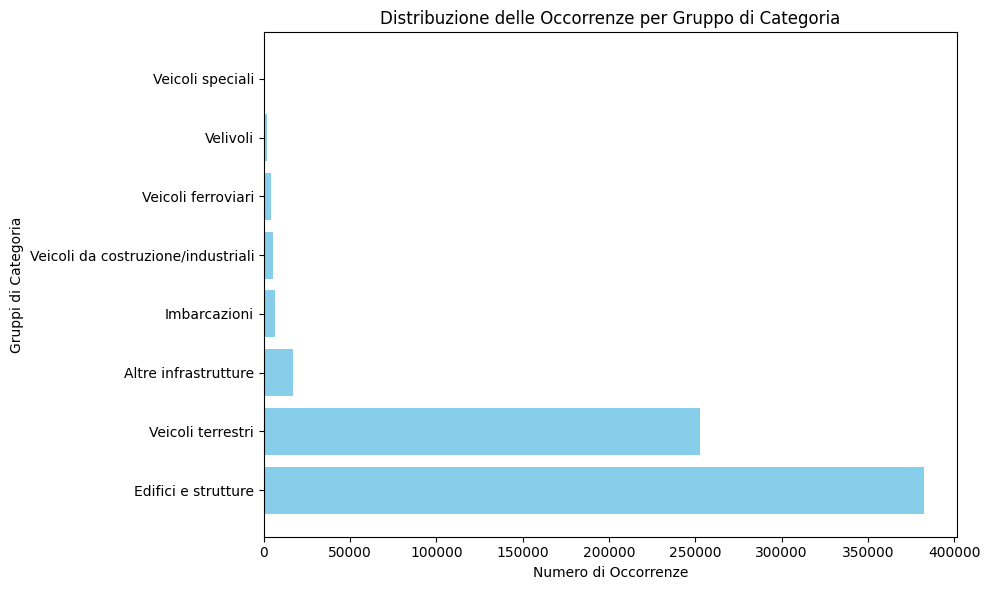

Gruppo: Veicoli speciali, Occorrenze Totali: 184
  category_id: 16, Categoria: Crane Truck, Occorrenze: 184


Gruppo: Velivoli, Occorrenze Totali: 1708
  category_id: 0, Categoria: Fixed-wing Aircraft, Occorrenze: 95
  category_id: 1, Categoria: Small Aircraft, Occorrenze: 407
  category_id: 2, Categoria: Passenger/Cargo Plane, Occorrenze: 1129
  category_id: 3, Categoria: Helicopter, Occorrenze: 77


Gruppo: Veicoli ferroviari, Occorrenze Totali: 4233
  category_id: 17, Categoria: Railway Vehicle, Occorrenze: 19
  category_id: 18, Categoria: Passenger Car, Occorrenze: 1758
  category_id: 19, Categoria: Cargo/Container Car, Occorrenze: 2036
  category_id: 20, Categoria: Flat Car, Occorrenze: 150
  category_id: 21, Categoria: Tank car, Occorrenze: 129
  category_id: 22, Categoria: Locomotive, Occorrenze: 141


Gruppo: Veicoli da costruzione/industriali, Occorrenze Totali: 5298
  category_id: 33, Categoria: Engineering Vehicle, Occorrenze: 232
  category_id: 34, Categoria: Tower crane, O

In [47]:
# Crea un dizionario per mappare category_id a categoria
category_mapping = {str(index): list(category.values())[0] for index, category in enumerate(coco_data['categories'])}

# Estrai i category_id dalle annotazioni
category_ids = [annotation['category_id'] for annotation in coco_data['annotations']]

# Conta le occorrenze di ogni category_id
category_counts = Counter(category_ids)

# Gruppi delle categorie
category_groups = {
    "Velivoli": [0, 1, 2, 3],
    "Veicoli terrestri": [4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15],
    "Veicoli speciali": [16],
    "Veicoli ferroviari": [17, 18, 19, 20, 21, 22],
    "Imbarcazioni": [23, 24, 25, 26, 27, 28, 29, 30, 31, 32],
    "Veicoli da costruzione/industriali": [33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45],
    "Edifici e strutture": [46, 47, 48, 49, 50, 51],
    "Altre infrastrutture": [52, 53, 54, 55, 56, 57, 58, 59]
}

# Crea un dizionario per le categorie aggregate con le loro occorrenze
grouped_occurrences = {}
for group_name, category_ids in category_groups.items():
    # Somma le occorrenze per le categorie di ogni gruppo
    grouped_occurrences[group_name] = sum(category_counts[cat_id] for cat_id in category_ids)

# Ordina le categorie raggruppate per occorrenze in ordine decrescente
grouped_occurrences = dict(sorted(grouped_occurrences.items(), key=lambda item: item[1], reverse=True))

# Prepara i dati per il grafico
groups = list(grouped_occurrences.keys())
occurrences = list(grouped_occurrences.values())


# Crea il grafico a barre
plt.figure(figsize=(10, 6))
plt.barh(groups, occurrences, color='skyblue')
plt.xlabel('Numero di Occorrenze')
plt.ylabel('Gruppi di Categoria')
plt.title('Distribuzione delle Occorrenze per Gruppo di Categoria')
plt.tight_layout()

# Mostra il grafico
plt.show()

# Stampare le occorrenze per ciascun group e i relativi ID
sorted_groups = sorted(category_groups.items(), key=lambda item: sum(category_counts.get(cat_id, 0) for cat_id in item[1]))

for group, category_ids in sorted_groups:
    # Calcola il numero totale di occorrenze per il gruppo
    total_count = sum(category_counts.get(cat_id, 0) for cat_id in category_ids)
    
    print(f"Gruppo: {group}, Occorrenze Totali: {total_count}")
    
    for cat_id in category_ids:
        category_name = category_mapping[str(cat_id)]
        count = category_counts.get(cat_id, 0)
        print(f"  category_id: {cat_id}, Categoria: {category_name}, Occorrenze: {count}")
    
    print("\n")

# DATALOADER

In [48]:
class CustomDataset(Dataset):
    def __init__(self, txt_file, img_dir, coco_json_file, aug=False):
        """
        Args:
            txt_file (str): percorso al file di testo con i nomi delle immagini.
            img_dir (str): directory contenente le immagini.
            coco_json_file (str): percorso al file JSON in formato COCO contenente le annotazioni.
            aug (bool): se True, applica le trasformazioni (augmentation).
        """
        # Leggi i percorsi delle immagini dal file di testo
        with open(txt_file, 'r') as f:
            self.image_paths = [line.strip() for line in f.readlines()]

        self.img_dir = img_dir
        
        # Carica il file COCO
        with open(coco_json_file, 'r') as f:
            coco_data = json.load(f)
        
        # Crea una mappatura delle categorie (category_id -> category_name)
        self.category_map = {str(i): category[str(i)] for i, category in enumerate(coco_data['categories'])}
        
        # Crea un dizionario delle annotazioni (image_id -> [category_ids])
        self.image_annotations = {}
        for annotation in coco_data['annotations']:
            image_id = annotation['image_id']
            category_id = str(annotation['category_id'])  # Assicurati che category_id sia una stringa
            if image_id not in self.image_annotations:
                self.image_annotations[image_id] = []
            self.image_annotations[image_id].append(category_id)
        
        # Crea un dizionario per i percorsi delle immagini (id -> file_name)
        self.image_info = {image['id']: image['file_name'] for image in coco_data['images']}
        
        self.coco_data = coco_data  # Salva il JSON completo, se necessario

        # Trasformazioni senza augmentation
        self.transform = transforms.Compose([
            transforms.Resize((320, 320)),  # Ridimensiona a 320x320
            transforms.ToTensor(),         # Converte in tensore
        ])

        # Trasformazioni con augmentation
        if aug:
            self.transform = transforms.Compose([
                transforms.RandomHorizontalFlip(),    # Flip orizzontale casuale
                transforms.RandomVerticalFlip(),      # Flip verticale casuale
                transforms.RandomRotation(degrees=45),# Rotazione casuale fino a ±45 gradi
                transforms.Resize((320, 320)),        # Ridimensiona uniformemente dopo augmentation
                transforms.ToTensor(),
            ])

    def __len__(self):
        return len(self.image_paths)
    
    def __getitem__(self, index):
        # Ottieni il nome dell'immagine
        img_name = os.path.basename(self.image_paths[index])

        # Trova l'id dell'immagine nel file COCO
        img_id = next((img_id for img_id, file_name in self.image_info.items() if file_name == img_name), None)
        if img_id is None:
            raise ValueError(f"Immagine {img_name} non trovata nel file COCO")

        # Carica l'immagine
        img_path = os.path.join(self.img_dir, img_name)
        if not os.path.exists(img_path):
            raise ValueError(f"Immagine non trovata nel percorso: {img_path}")

        image = Image.open(img_path).convert('RGB')

        # Applica le trasformazioni
        image = self.transform(image)

        # Estrai le categorie associate a questa immagine
        categories = self.image_annotations.get(img_id, [])
        label = [self.category_map[cat_id] for cat_id in categories]

        return image, label

In [49]:
def collate_fn(batch):
    images, labels = zip(*batch)
    return list(images), list(labels)

In [50]:
# Creazione dei dataset
train_dataset = CustomDataset(train_txt_pth, save_images_fldr_pth, coco_json_pth, aug=True)
valid_dataset = CustomDataset(val_txt_pth, save_images_fldr_pth, coco_json_pth, aug=False)  # Nessuna augmentazione per la validazione
test_dataset = CustomDataset(test_txt_pth, save_images_fldr_pth, coco_json_pth, aug=False)  # Nessuna augmentazione per il test

# Creazione dei DataLoader
train_loader = DataLoader(train_dataset, batch_size=128, shuffle=True, collate_fn=collate_fn)
val_loader = DataLoader(valid_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)
test_loader = DataLoader(test_dataset, batch_size=128, shuffle=False, collate_fn=collate_fn)

In [51]:
def check_txt_vs_json(txt_path, coco_data):
    # Estrai i nomi delle immagini dal JSON
    image_names = [image['file_name'] for image in coco_data['images']]
    
    # Leggi e normalizza i nomi delle immagini dal file TXT
    with open(txt_path, 'r') as f:
        txt_image_names = [os.path.basename(line.strip()) for line in f.readlines()]
    
    # Trova le immagini presenti nel TXT ma non nel JSON
    missing_in_json = [name for name in txt_image_names if name not in image_names]
    
    # Trova le immagini presenti nel JSON ma non nel TXT
    missing_in_txt = [name for name in image_names if name not in txt_image_names]
    
    print(f"\nControllo per il file TXT: {txt_path}")
    if missing_in_json:
        print("Ci sono immagini del TXT che NON sono presenti nel JSON")
    else:
        print("Tutte le immagini del TXT sono presenti nel JSON.")
    
    if missing_in_txt:
        print("Ci sono immagini del JSON che NON sono presenti nel TXT")
    else:
        print("Tutte le immagini del JSON sono presenti nel TXT.")

In [52]:
# Conta il numero di immagini nel JSON
num_images = len(coco_data['images'])
print(f"Numero di immagini nel JSON: {num_images}")

Numero di immagini nel JSON: 72477


In [53]:
check_txt_vs_json(train_txt_pth, coco_data)


Controllo per il file TXT: /kaggle/working/YOLO_cfg/train.txt
Tutte le immagini del TXT sono presenti nel JSON.
Ci sono immagini del JSON che NON sono presenti nel TXT


In [54]:
check_txt_vs_json(val_txt_pth, coco_data)


Controllo per il file TXT: /kaggle/working/YOLO_cfg/train.txt
Tutte le immagini del TXT sono presenti nel JSON.
Ci sono immagini del JSON che NON sono presenti nel TXT


In [55]:
check_txt_vs_json(test_txt_pth, coco_data)


Controllo per il file TXT: /kaggle/working/YOLO_cfg/test.txt
Tutte le immagini del TXT sono presenti nel JSON.
Ci sono immagini del JSON che NON sono presenti nel TXT


In [56]:
def check_dataloader(loader):
    missing_images_count = 0
    for batch in loader:
        images, labels = batch
        
        try:
            # Gestione di nomi di immagini come liste
            if isinstance(labels[0], list):  # labels è una lista di liste
                for label_group in labels:
                    for label in label_group:
                        img_name = os.path.basename(label)
            elif isinstance(labels[0], str):  # labels è una lista di stringhe
                img_name = os.path.basename(labels[0])
            else:
                print("Formato delle etichette sconosciuto:", type(labels[0]))

            # Verifica se ci sono immagini nel batch
            if images is None or images.shape[0] == 0:
                missing_images_count += 1

        except Exception as e:
            print(f"Errore nel batch: {e}")
    
    print(f"\nTotale batch senza immagini: {missing_images_count}")


# Esegui il check sul DataLoader
check_dataloader(train_loader)
check_dataloader(val_loader)
check_dataloader(test_loader)

ValueError: Immagine img_2064_0_2240.jpg non trovata nel file COCO

# MODELLI
Modelli scelti:
* [R-CNN con backbone AlexNet](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)
* [SPPNet con backbone ZF-5](https://arxiv.org/pdf/1406.4729)
* [Faster R-CNN con backbone VGG16](https://medium.com/@fractal.ai/guide-to-build-faster-rcnn-in-pytorch-42d47cb0ecd3)

## R-CNN (AlexNet)

In [ ]:
import torch
import torch.nn as nn
from torchvision import models

class RCNNModel(nn.Module):
    def __init__(self, base_model='alexnet', num_classes=61):  # 60 classi + sfondo
        super(RCNNModel, self).__init__()
        # AlexNet pre-addestrata
        alexnet = models.alexnet(pretrained=True)
        self.backbone = nn.Sequential(*list(alexnet.children())[:-2])  # Rimuovi i layer Fully Connected (FC)
        
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))  # Pooling adattivo
        
        # Classificatore per multi-classe
        self.classifier = nn.Sequential(
            nn.Linear(alexnet.classifier[1].in_features, 512),  # Numero di feature dal penultimo layer
            nn.ReLU(),
            nn.Linear(512, num_classes)  # Numero di classi
        )

    def forward(self, x):
        # Estrai feature dalla backbone
        x = self.backbone(x)
        x = self.avgpool(x)
        x = torch.flatten(x, 1)
        # Classificazione multi-classe
        class_logits = self.classifier(x)
        return class_logits


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

class Trainer:
    def __init__(self, model, train_loader, val_loader, num_classes, device='cuda'):
        """
        Classe per il training e la validazione di un modello RCNN.
        Args:
            model (nn.Module): il modello da addestrare.
            train_loader (DataLoader): dataloader per il set di training.
            val_loader (DataLoader): dataloader per il set di validazione.
            num_classes (int): numero di classi (incluso lo sfondo).
            device (str): dispositivo per l'addestramento ('cuda' o 'cpu').
        """
        self.model = model.to(device)
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.device = device
        self.num_classes = num_classes
        
        # Funzione di perdita per classificazione multi-classe
        self.criterion = nn.CrossEntropyLoss()
        
        # Ottimizzatore
        self.optimizer = optim.Adam(self.model.parameters(), lr=1e-4)
        
        # Per tenere traccia della storia di training e validazione
        self.history = {'train_loss': [], 'val_loss': [], 'val_acc': []}
    
    def train_one_epoch(self):
        """Esegue un'epoca di training."""
        self.model.train()
        running_loss = 0.0
        
        for images, labels in self.train_loader:
            images = images.to(self.device)
            labels = labels.to(self.device)
            
            # Forward pass
            outputs = self.model(images)
            loss = self.criterion(outputs, labels)
            
            # Backward pass
            self.optimizer.zero_grad()
            loss.backward()
            self.optimizer.step()
            
            running_loss += loss.item() * images.size(0)  # Accumula la perdita totale
        
        # Calcola la perdita media
        epoch_loss = running_loss / len(self.train_loader.dataset)
        return epoch_loss
    
    def validate(self):
        """Esegue la validazione sul set di validazione."""
        self.model.eval()
        running_loss = 0.0
        correct = 0
        total = 0
        
        with torch.no_grad():
            for images, labels in self.val_loader:
                images = images.to(self.device)
                labels = labels.to(self.device)
                
                # Forward pass
                outputs = self.model(images)
                loss = self.criterion(outputs, labels)
                running_loss += loss.item() * images.size(0)
                
                # Calcolo accuratezza
                _, preds = torch.max(outputs, 1)  # Predizioni con probabilità massima
                correct += (preds == labels).sum().item()
                total += labels.size(0)
        
        # Calcola la perdita media e accuratezza
        epoch_loss = running_loss / len(self.val_loader.dataset)
        accuracy = correct / total
        return epoch_loss, accuracy
    
    def train(self, num_epochs):
        """Esegue il training e la validazione per un numero di epoche."""
        for epoch in range(num_epochs):
            print(f"Epoch {epoch+1}/{num_epochs}")
            
            # Training
            train_loss = self.train_one_epoch()
            print(f"Train Loss: {train_loss:.4f}")
            
            # Validazione
            val_loss, val_acc = self.validate()
            print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")
            
            # Salva i risultati
            self.history['train_loss'].append(train_loss)
            self.history['val_loss'].append(val_loss)
            self.history['val_acc'].append(val_acc)
    
    def save_model(self, path):
        """Salva il modello addestrato."""
        torch.save(self.model.state_dict(), path)
        print(f"Modello salvato in {path}")
    
    def load_model(self, path):
        """Carica un modello addestrato."""
        self.model.load_state_dict(torch.load(path))
        self.model.to(self.device)
        print(f"Modello caricato da {path}")


In [ ]:
import numpy as np

def test_model(test_image_path, model, top_k=2000):
    # Carica l'immagine
    image = cv2.imread(test_image_path)
    image_rgb = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    
    # Genera region proposals con Selective Search
    ss = cv2.ximgproc.segmentation.createSelectiveSearchSegmentation()
    ss.setBaseImage(image)
    ss.switchToSelectiveSearchFast()
    ss_results = ss.process()[:top_k]  # Prendi le prime 2000 proposte
    
    # Trasforma region proposals in tensor
    transform = transforms.Compose([
        transforms.Resize((224, 224)),
        transforms.ToTensor()
    ])
    proposals = []
    for region in ss_results:
        x, y, w, h = region
        cropped = image_rgb[y:y + h, x:x + w]
        resized = cv2.resize(cropped, (224, 224), interpolation=cv2.INTER_AREA)
        proposals.append(transform(Image.fromarray(resized)))
    proposals = torch.stack(proposals)  # Shape: (top_k, 3, 224, 224)
    
    # Predizioni del modello
    model.eval()
    with torch.no_grad():
        class_logits = model(proposals)
        predictions = torch.argmax(class_logits, dim=1).cpu().numpy()  # 0 o 1
    
    # Filtra region proposals positive
    positive_regions = [ss_results[i] for i in range(len(predictions)) if predictions[i] == 1]
    
    return positive_regions


In [ ]:
'''
# Carica il backbone AlexNet
alexnet = models.alexnet(pretrained=True)

# Costruisci l'architettura R-CNN (personalizza in base alle tue esigenze)
class RCNN(nn.Module):
    def __init__(self, backbone):
        super(RCNN, self).__init__()
        self.backbone = nn.Sequential(*list(backbone.children())[:-1])
        # Aggiungi livelli completamente connessi e ROI pooling
        # Definisci qui ulteriori strati
        
    def forward(self, x):
        x = self.backbone(x)
        # Implementa forward pass specifico per R-CNN
        return x

rcnn_model = RCNN(alexnet)
'''

## SPPNet (ZF-5)

In [ ]:
'''
class SPPNet(nn.Module):
    def __init__(self):
        super(SPPNet, self).__init__()
        # Definisci il modello ZF-5 (convoluzioni e pooling)
        # Implementa i livelli SPP

    def forward(self, x):
        # Calcola il forward pass con SPP
        return x

sppnet_model = SPPNet()
'''

## Faster R-CNN (VGG16)

In [ ]:
'''
from torchvision.models.detection import fasterrcnn_resnet50_fpn

# Usa il backbone VGG16
vgg16_backbone = models.vgg16(pretrained=True).features

# Carica Faster R-CNN con backbone personalizzato
faster_rcnn_model = fasterrcnn_resnet50_fpn(pretrained=True)
faster_rcnn_model.backbone = vgg16_backbone
'''